In [1]:
from astropy.table import Table, join, Column
from astropy import units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read Gaia DR2 IERS quasar data
from my_progs.vlbi.read_sou import read_sou
from my_progs.catalog.pos_diff import radio_cat_diff_calc
from my_progs.catalog.read_icrf import read_icrf3
from my_progs.vlbi.sou_func import read_crf

icrf3 = read_icrf3(wv="sx")
# opa2019a = read_sou("../data/nju2021a.sou", drop_few_obs=True, nobs_lim=3)
opa2019a = read_crf("../data/ivs-solutions/opa2021a.crf",
                    drop_few_obs=True, analy_cen="opa")

There are 5117 sources in the original catalog, 1 (0%) sources with #obs < 3 dropped, leaving 5116 sources in the present catalog.


In [3]:
# Calculate the positional difference of 'opa2019a - ICRF3'
catdif1 = radio_cat_diff_calc(opa2019a, icrf3, sou_name="iers_name")

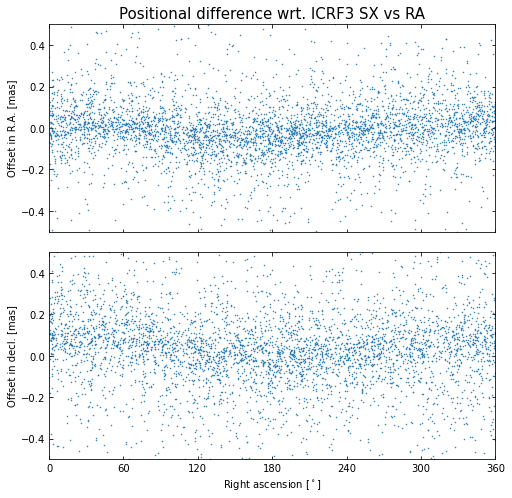

In [4]:
fig, (ax0, ax1) = plt.subplots(figsize=(8, 8), nrows=2, sharex=True)

ax0.plot(catdif1["ra"], catdif1["dra"], ".", ms=1)
ax1.plot(catdif1["ra"], catdif1["ddec"], ".", ms=1)

ax1.set_xlabel("Right ascension [$^\circ$]")
ax0.set_ylabel("Offset in R.A. [mas]")
ax1.set_ylabel("Offset in decl. [mas]")

ax1.set_xticks(np.arange(0, 361, 60))

ax0.set_xlim([0, 360])
ax0.set_ylim([-0.5, 0.5])
ax1.set_ylim([-0.5, 0.5])

ax0.set_title("Positional difference wrt. ICRF3 SX vs RA", fontsize=15)

plt.subplots_adjust(hspace=0.1)

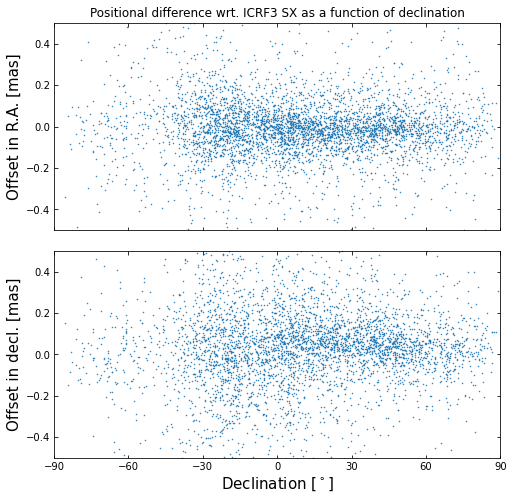

In [5]:
fig, (ax0, ax1) = plt.subplots(figsize=(8, 8), nrows=2, sharex=True)

ax0.plot(catdif1["dec"], catdif1["dra"], ".", ms=1)
ax1.plot(catdif1["dec"], catdif1["ddec"], ".", ms=1)

ax1.set_xlabel("Declination [$^\circ$]", fontsize=15)
ax0.set_ylabel("Offset in R.A. [mas]", fontsize=15)
ax1.set_ylabel("Offset in decl. [mas]", fontsize=15)

ax1.set_xticks(np.arange(-90, 91, 30))

ax0.set_xlim([-90, 90])
ax0.set_ylim([-0.5, 0.5])
ax1.set_ylim([-0.5, 0.5])

ax0.set_title("Positional difference wrt. ICRF3 SX as a function of declination")

plt.subplots_adjust(hspace=0.1)
# plt.savefig("offset-dec.png")

In [6]:
# My modules
from my_progs.catalog.vsh_deg2_cor import vsh_deg02_fitting

# Transform columns into np.array
dra1 = np.array(catdif1["dra"])
ddec1 = np.array(catdif1["ddec"])
dra_err1 = np.array(catdif1["dra_err"])
ddec_err1 = np.array(catdif1["ddec_err"])
ra_rad1 = np.array(catdif1["ra"].to(u.radian))
dec_rad1 = np.array(catdif1["dec"].to(u.radian))
dra_ddec_cov1 = np.array(catdif1["dra_ddec_cov"])

# Transformation parameters
# l_max = 2
par1, sig1, _ = vsh_deg02_fitting(
    dra1, ddec1, ra_rad1, dec_rad1, dra_err1, ddec_err1,
#     cov=dra_ddec_cov1, elim_flag="None")
         elim_flag="None")

# mas -> uas
par1 = par1 * 1.e3
sig1 = sig1 * 1.e3

# Print results
print("Estimates (%6d sources)\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "                 Rotation [uas]                  "
      "                 Glide [uas]               \n"
      "             x             y             z"
      "             x             y             z\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "        %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f"
      "        %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "----------------------------------------------"
      "----------------------------------------------\n" %
      (dra1.size,
       par1[3], sig1[3], par1[4], sig1[4], par1[5], sig1[5],
       par1[0], sig1[0], par1[1], sig1[1], par1[2], sig1[2],))

quad_names = Column(["ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])

print("Positional difference")
t_quad1 = Table([quad_names, par1[6:], sig1[6:]],
                names=["Quadrupolar term", "Estimate", "Error"])
t_quad1["Estimate"].format = "%5.0f"
t_quad1["Error"].format = "%5.0f"
print(t_quad1)

Estimates (  4490 sources)
--------------------------------------------------------------------------------------------
                 Rotation [uas]                                   Glide [uas]               
             x             y             z             x             y             z
--------------------------------------------------------------------------------------------
         +23 +/-  11   -42 +/-  11    -8 +/-   7         +25 +/-   9   +41 +/-   9   +38 +/-  11
--------------------------------------------------------------------------------------------

Positional difference
Quadrupolar term Estimate Error
---------------- -------- -----
            ER22       -9     5
            EI22        0     5
            ER21        6    12
            EI21      -15    12
             E20       15    12
            MR22       -3     6
            MI22       -5     6
            MR21      -14    11
            MI21       10    12
             M20       -4     9


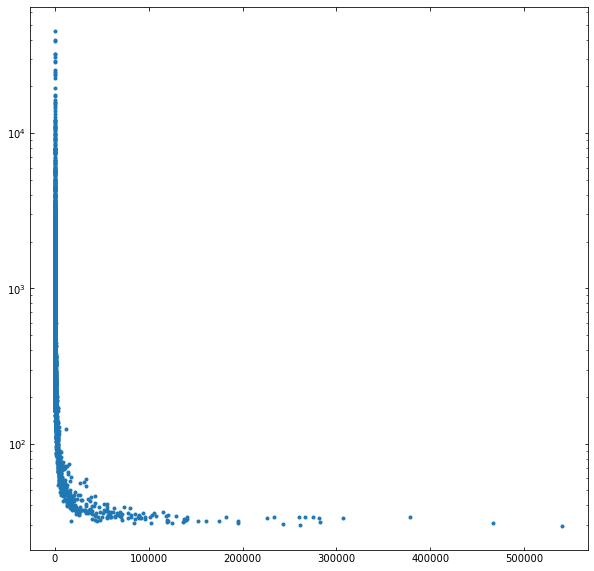

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(opa2019a["used_obs"], opa2019a["pos_err"], ".")

ax.set_yscale("log")